<a href="https://colab.research.google.com/github/sushmita56/Image-Caption-Generation/blob/master/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import numpy as np

from tqdm.notebook import tqdm    # tqdm create simple & hassle-free progress bars
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poudelsushmita","key":"5f195b261254924e6df6289c4f0f1193"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:06<00:00, 220MB/s]
100% 1.04G/1.04G [00:06<00:00, 180MB/s]


In [ ]:
# ! rm -rf Images

In [6]:
! unzip /content/flickr8k.zip -d /content/flickr8k 


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [7]:
base_model = VGG16()
base_model.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
! pwd

/content


In [10]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content'

In [11]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size=(224,224))
  # convert image pixels to numpy array
  image =img_to_array(image)
  # reshape data for model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # preprocess image for vgg
  image = preprocess_input(image)
  # extract features
  feature = model.predict(image, verbose=0)
  # get image ID
  image_id = img_name.split('.')[0]
  # store feature
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [12]:
# store preprocessed features 
pickle.dump(features, open(os.path.join(WORKING_DIR, 'processed_features.pkl'), 'wb'))

In [13]:
# load stored features from pickle
with open(os.path.join(WORKING_DIR, 'processed_features.pkl'), 'rb') as f:
  features = pickle.load(f)

# Load the caption data

In [14]:
BASE_DIR

'/content/flickr8k'

In [15]:
# load the caption data from captions.txt file that is inside flickr8k
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
  next(f)
  image_captions = f.read()

In [16]:
# for each image id we've their corresponding caption
# for this let's create a mapping of an image to its corresponding caption
caption_mapping = {}
# process lines
for line in tqdm(image_captions.split('\n')):
    # again split each line by comma as the file name and caption is separated by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove .jpg extendion from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # if image id is not in caption mapping dictionary, we add the image_id onto the dictionary
    # else if image_id already exists on the dictionary then we will store caption of the corresponding image_id
    if image_id not in caption_mapping:
        caption_mapping[image_id] = []
    # store the caption
    caption_mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
len(caption_mapping)

8091

In [18]:
def preprocess_caption(caption_mapping):
  for id, captions in caption_mapping.items():
    for i in range(len(captions)):
      # process 1 caption at a time
      caption = captions[i]
      caption = caption.lower()
      # delete everything like digits, special characters except alphabets
      caption = caption.replace('[^A-Za-z]', '')
      caption = caption.replace('\s+', ' ')          
      # add start and end tag to caption
      # default separator in split() function is any whitespace
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq' 
      captions[i] = caption

In [19]:
# before text processing
caption_mapping['1002674143_1b742ab4b8']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

In [20]:
preprocess_caption(caption_mapping)

In [21]:
# after text processing
caption_mapping['1002674143_1b742ab4b8']

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

In [22]:
all_captions = []
for key in caption_mapping:
    for value in caption_mapping[key]:
        all_captions.append(value)

In [23]:
all_captions[5:10]

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [29]:
# get maximum length of the caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [25]:
image_ids = list(caption_mapping.keys())
split = int(len(image_ids) * 0.9)
train = image_ids[:split]   # take 90% of data as training data
test = image_ids[split:]    # remaining 10% will be used as a test data

In [27]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

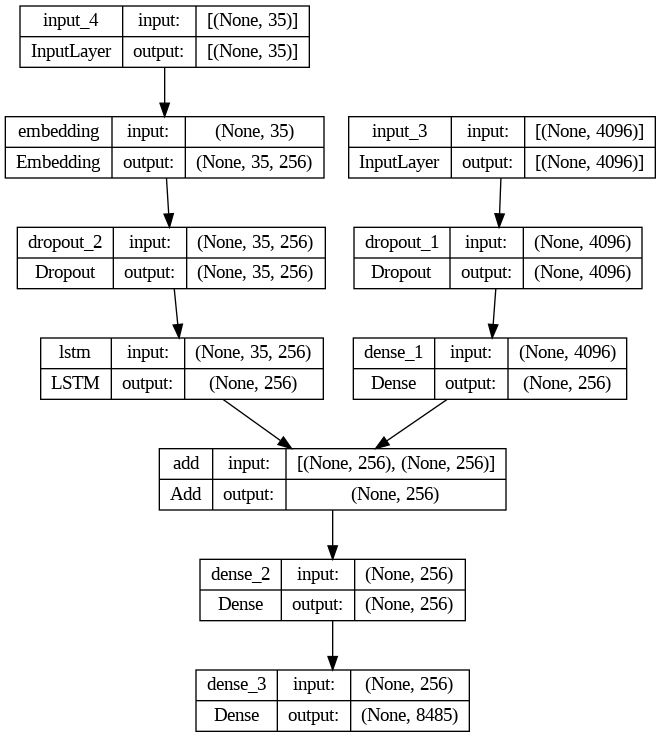

In [30]:
inputs1 = Input(shape=(4096,))  # the output of vgg model i.e. 4096 will be used as an input
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, caption_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

 47/113 [===========>..................] - ETA: 22s - loss: 3.5885

In [ ]:
# save the model
model.save(WORKING_DIR + '/caption_model2.h5')

# Generate captions for image

In [ ]:
# we've to conver image id to word at first
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
  in_text = 'startseq'
  # iterate over max_length of the sequnece
  for i in range(max_length):
    # encode sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad sequence
    sequence = pad_sequences([sequence], max_length)
    # predict next word
    y_hat = model.predict([image, sequence], verbose=0)
    # get index with high probability
    y_hat = np.argmax(y_hat)
    # convert index to word or caption
    word = idx_to_word(y_hat)
    # stop if word not found:
    if word is None:
      break
    # append word as input for generating next word
    in_text += " " + word
    # stop if we reach end tag
    if word == 'endseq':
      break
  return in_text

## Model Evaluation

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
tokenizer

In [ ]:
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = caption_mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  # split actual caption into multiple words
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

TypeError: ignored